# Imports

In [26]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#R-Factor and MOS Computation

In [2]:
# reading in our integrated dataset
df = pd.read_csv('integrated_data.csv')
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0


In [3]:
# Computing average latency with rtt_avg feature (rtt is approximately double than(or greater than double) of rtt)
# So we considered rtt average as a good(conservative) appromixate for it
df['average_latency'] = df['rtt_avg']/2
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0,38.9155
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0,38.2775
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0,38.5490
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0,38.1530


In [4]:
# Computing the effective latency for the R-factor and MOS calculations 
# Effective latency is dependent on average latency and jitter.
# So effective_latency = average_latency + jitter * 2 + 10
df['effective_latency'] = df['average_latency'] + df['jitter']*2 + 10
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency,effective_latency
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685,23.972090
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070,17.764895
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590,243.051308
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355,18.882868
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415,292.523551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0,38.9155,146.120013
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0,38.2775,148.394013
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0,38.5490,134.294077
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0,38.1530,151.529154


In [5]:
# Now next step is to calculate R factor, which involves using the effective latency
# computed earlier. So if the effective latency is less than 160 then we dont do a very 
# agressive deduction in the initial value of R factor.

# In case it is higher than 160, then we do a very aggressive deduction in R factor based
# on the formula given on https://www.pingman.com/kb/article/how-is-mos-calculated-in-pingplotter-pro-50.html

# So using this, the loop goes over all the datapoints and computes a R-factor for each data point.
R_factors = []

for row in df.iterrows():
    # print(row[1].effective_latency)
    effective_latency = row[1]['effective_latency']
    if effective_latency < 160:
        R_factors.append(93.2 - (effective_latency/40))
    else:
        R_factors.append(93.2 - ((effective_latency - 120)/10))

df['R_factor'] = R_factors
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency,effective_latency,R_factor
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685,23.972090,92.600698
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070,17.764895,92.755878
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590,243.051308,80.894869
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355,18.882868,92.727928
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415,292.523551,75.947645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0,38.9155,146.120013,89.547000
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0,38.2775,148.394013,89.490150
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0,38.5490,134.294077,89.842648
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0,38.1530,151.529154,89.411771


In [6]:
# We need to alter R_factor based on the packet loss count which we have calculated.
# So for 2.5 R value is deducted per percentage of R-factor 
df['R_factor'] = df['R_factor'] - ((df['packet_loss_count']/40) * 2.5)
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency,effective_latency,R_factor
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685,23.972090,92.600698
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070,17.764895,92.693378
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590,243.051308,80.894869
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355,18.882868,92.665428
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415,292.523551,75.947645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0,38.9155,146.120013,89.547000
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0,38.2775,148.394013,89.490150
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0,38.5490,134.294077,89.842648
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0,38.1530,151.529154,89.411771


In [7]:
#df.sort_values(by=['R_factor'], inplace=True)

In [8]:
# Finally we calculate the MOS value based off of our R-factor value for each data point.

# MOS value is a voice over IP quality metric. Because it is dependent on factors that are essential for
# Voice over IP such as latency, jitter and packet loss rate, which we believe are factors that have a significant effect
# on the quality of the wifi network connection, we think that it is a good output metric to train our model on.

# In general circumstances, MOS is calculated on both ends of the call, but in the article that we are following, their formula
# is generalized for anything to be on the other side which could be a person, web server or antyhing else. This is why
# we think it is general enough to be our wifi quality output metric.

# We will use this MOS value which we will compute based on the formula based from the following article:
# https://www.pingman.com/kb/article/how-is-mos-calculated-in-pingplotter-pro-50.html
# which is given as follows:
# MOS = 1 + (0.035) * R + (.000007) * R * (R-60) * (100-R)
# where R is the R factor (Range between 0 to 100)
# Another point to note is that MOS value is between 1 to 5, where 5 is the best, 1 is worst
df['MOS'] = 1 + (0.035) * df['R_factor'] + (0.000007) * df['R_factor'] * (df['R_factor'] - 60) * (100 - df['R_factor'])
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency,effective_latency,R_factor,MOS
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685,23.972090,92.600698,4.397386
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070,17.764895,92.693378,4.399265
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590,243.051308,80.894869,4.057373
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355,18.882868,92.665428,4.398700
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415,292.523551,75.947645,3.862091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0,38.9155,146.120013,89.547000,4.327744
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0,38.2775,148.394013,89.490150,4.326309
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0,38.5490,134.294077,89.842648,4.335126
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0,38.1530,151.529154,89.411771,4.324323


# Outlier Removal

In [9]:
# Just looking at stats for MOS to make sure the range of MOS is correct before 
# we use it for our Regression model
df['MOS'].describe()

count    1284.000000
mean        5.462946
std        36.516855
min         1.002796
25%         4.041882
50%         4.364037
75%         4.395703
max      1260.076703
Name: MOS, dtype: float64

In [10]:
# Fixing the MOS and R_factor value outliers by removing those datapoints.
# Overall removing these outliers was better than imputing because there were only 5 such datapoints.
df = df.loc[df['MOS'] < 5]
df = df.loc[(df['R_factor'] > 0) & (df['R_factor'] < 100)]
df

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency,effective_latency,R_factor,MOS
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685,23.972090,92.600698,4.397386
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070,17.764895,92.693378,4.399265
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590,243.051308,80.894869,4.057373
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355,18.882868,92.665428,4.398700
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.913390,-73.132210,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415,292.523551,75.947645,3.862091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,discord.com,40.0,40.0,0.0,0.0,6.849,77.831,342.538,92.057,0.0,0.0,48.602256,0.0,0.0,38.9155,146.120013,89.547000,4.327744
1280,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,quizlet.com,40.0,40.0,0.0,0.0,9.545,76.555,306.264,63.958,0.0,0.0,50.058256,0.0,0.0,38.2775,148.394013,89.490150,4.326309
1281,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,github.com,40.0,40.0,0.0,0.0,15.892,77.098,244.655,62.112,0.0,0.0,42.872538,0.0,0.0,38.5490,134.294077,89.842648,4.335126
1282,WolfieNet-Secure,-58,5.898175e+06,1.469534e+07,NorthReadingRoom-F1,40.916034,-73.122723,WolfieNet-Secure,psns.cc.stonybrook.edu,40.0,40.0,0.0,0.0,9.131,76.306,324.948,74.961,0.0,0.0,51.688077,0.0,0.0,38.1530,151.529154,89.411771,4.324323


# Correlation matrix

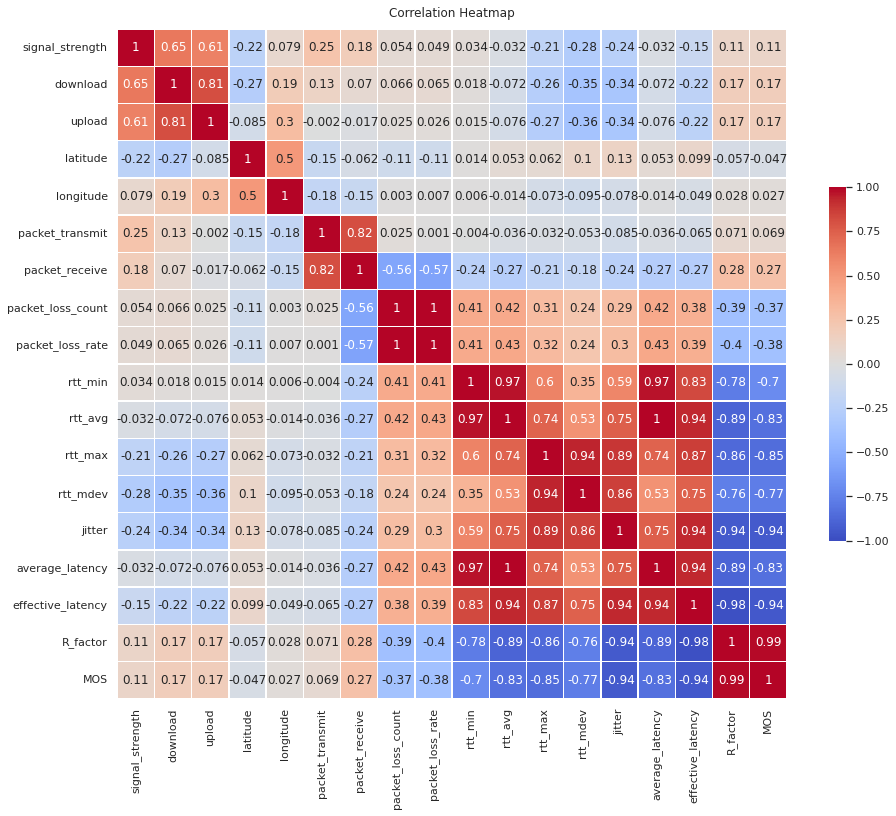

In [28]:
# Now we will generate the correlation matrix between all the numerical features to see how the relationships
# between them. We can later use this to do feature reduction in our LR+ model.
corr = df[['signal_strength', 'download', 'upload', 'latitude', 'longitude', 'packet_transmit', 'packet_receive',
    'packet_loss_count', 'packet_loss_rate', 'rtt_min', 'rtt_avg', 'rtt_max', 'rtt_mdev', 'jitter', 'average_latency',
    'effective_latency', 'R_factor', 'MOS']].corr().round(3)

f, ax = plt.subplots(figsize=(15, 13))

cmap = sns.color_palette("coolwarm", as_cmap=True)

heatmap = sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, annot=True, linewidths=.5, square=True, cbar_kws={"shrink": .5});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [12]:
df[['signal_strength', 'download', 'upload', 'latitude', 'longitude', 'packet_transmit', 'packet_receive',
    'packet_loss_count', 'packet_loss_rate', 'rtt_min', 'rtt_avg', 'rtt_max', 'rtt_mdev', 'jitter', 'average_latency',
    'effective_latency', 'R_factor', 'MOS']].corr()['MOS']

signal_strength      0.110402
download             0.174036
upload               0.174379
latitude            -0.046834
longitude            0.026791
packet_transmit      0.068692
packet_receive       0.272445
packet_loss_count   -0.373453
packet_loss_rate    -0.381704
rtt_min             -0.701566
rtt_avg             -0.829061
rtt_max             -0.847591
rtt_mdev            -0.767560
jitter              -0.935071
average_latency     -0.829061
effective_latency   -0.943252
R_factor             0.990362
MOS                  1.000000
Name: MOS, dtype: float64

# Multiple Linear Regression

In [13]:
df.head()

,ssid,signal_strength,download,upload,location,latitude,longitude,wifi_name,destination,packet_transmit,packet_receive,packet_loss_count,packet_loss_rate,rtt_min,rtt_avg,rtt_max,rtt_mdev,packet_duplicate_count,packet_duplicate_rate,jitter,loss_rate,loss_count,average_latency,effective_latency,R_factor,MOS
0,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.91339,-73.13221,eduroam,google.com,40.0,40.0,0.0,0.0,9.547,12.937,52.278,7.213,0.0,0.0,3.751795,0.0,0.0,6.4685,23.972090,92.600698,4.397386
1,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.91339,-73.13221,eduroam,youtube.com,40.0,39.0,1.0,2.5,10.032,11.614,13.654,0.744,0.0,0.0,0.978947,2.5,1.0,5.8070,17.764895,92.693378,4.399265
2,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.91339,-73.13221,eduroam,tmall.com,40.0,40.0,0.0,0.0,247.545,310.718,370.803,34.253,0.0,0.0,38.846154,0.0,0.0,155.3590,243.051308,80.894869,4.057373
3,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.91339,-73.13221,eduroam,facebook.com,40.0,39.0,1.0,2.5,11.671,13.271,17.899,1.166,0.0,0.0,1.123684,2.5,1.0,6.6355,18.882868,92.665428,4.398700
4,eduroam,-44,2.225958e+08,2.192850e+08,SchomburgA,40.91339,-73.13221,eduroam,qq.com,40.0,40.0,0.0,0.0,222.477,298.483,477.298,66.467,0.0,0.0,66.641026,0.0,0.0,149.2415,292.523551,75.947645,3.862091


In [14]:
df.columns

Index(['ssid', 'signal_strength', 'download', 'upload', 'location', 'latitude',
       'longitude', 'wifi_name', 'destination', 'packet_transmit',
       'packet_receive', 'packet_loss_count', 'packet_loss_rate', 'rtt_min',
       'rtt_avg', 'rtt_max', 'rtt_mdev', 'packet_duplicate_count',
       'packet_duplicate_rate', 'jitter', 'loss_rate', 'loss_count',
       'average_latency', 'effective_latency', 'R_factor', 'MOS'],
      dtype='object')

In [15]:
# R_factor, effective_latency and jitter were used to compute the MOS values

# so it overfit our model if they were included because of their very high correlation values
# So to we will keep numerical features with significant correlation values except for R-factor, effective-latency 
# and jitter
X = df[['signal_strength', 'download', 'upload', 'packet_loss_rate', 'rtt_min', 
        'rtt_avg', 'rtt_max', 'rtt_mdev', 'average_latency']]

y = df[['MOS']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression().fit(X_train, y_train)

In [16]:
# Predit on X_test split
y_pred = reg.predict(X_test)

In [17]:
# Ensuring the test df has the right shape
print(X_test.shape, y_test.shape)

(420, 9) (420, 1)


In [30]:
# Creating a df with feature to plot against
plot_df = pd.DataFrame()
plot_df['download'] = X_test['download']
plot_df['y_test'] = y_test
plot_df['y_pred'] = y_pred
plot_df.sort_values(by=['download'], inplace=True)
plot_df

,download,y_test,y_pred
1266,5.898175e+06,3.433278,3.171533
1258,5.898175e+06,1.788264,2.741723
1270,5.898175e+06,4.126028,3.735900
1271,5.898175e+06,4.346538,4.223642
1274,5.898175e+06,4.330329,4.126138
...,...,...,...
88,2.544044e+08,4.391003,4.447283
96,2.544044e+08,4.396608,4.460396
100,2.544044e+08,4.397973,4.467405
76,2.544044e+08,4.059457,3.905664


Coefficients: 
 [[-9.16708552e-04  4.30748322e-11 -3.36057233e-10 -2.68420578e-03
   6.14424893e-03 -5.23174220e-03 -1.88059251e-04  1.86374574e-04
  -2.61587110e-03]]
Mean squared error: 0.03
Coefficient of determination: 0.87


Text(0.5, 1.0, "Goodness of fit for 'download'")

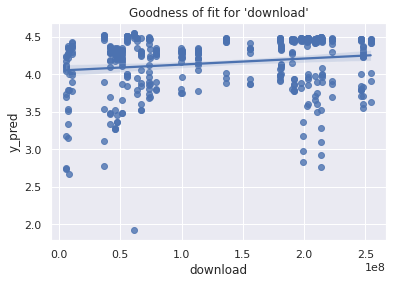

In [31]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

import seaborn as sns
sns.set_theme(color_codes=True)

regplt = sns.regplot(x="download", y="y_pred", data=plot_df)
regplt.set_title("Goodness of fit for 'download'")

In [32]:
# Creating a df with feature to plot against
plot_df = pd.DataFrame()
plot_df['average_latency'] = X_test['average_latency']
plot_df['y_test'] = y_test
plot_df['y_pred'] = y_pred
plot_df.sort_values(by=['average_latency'], inplace=True)
plot_df

,average_latency,y_test,y_pred
380,2.6375,4.402566,4.486232
23,2.6785,4.402090,4.472401
30,2.6930,4.402308,4.476436
299,2.6930,4.402016,4.488171
138,2.8655,4.401272,4.498315
...,...,...,...
394,241.8765,2.918007,3.363236
566,246.4275,3.181043,3.365160
129,252.9940,2.651884,3.287296
497,266.3090,2.034982,2.674610


Text(0.5, 1.0, "Goodness of fit for 'average_latency'")

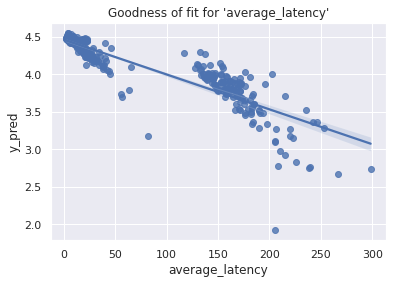

In [33]:
regplt = sns.regplot(x="average_latency", y="y_pred", data=plot_df)
regplt.set_title("Goodness of fit for 'average_latency'")

In [34]:
# Creating a df with feature to plot against
plot_df = pd.DataFrame()
plot_df['packet_loss_rate'] = X_test['packet_loss_rate']
plot_df['y_test'] = y_test
plot_df['y_pred'] = y_pred
plot_df.sort_values(by=['packet_loss_rate'], inplace=True)
plot_df

,packet_loss_rate,y_test,y_pred
1266,0.000000,3.433278,3.171533
932,0.000000,4.363848,4.323254
567,0.000000,4.351637,4.272775
578,0.000000,4.360039,4.257038
621,0.000000,4.366450,4.285580
...,...,...,...
796,17.500000,3.897175,3.706468
107,20.000000,3.213050,3.097318
738,32.500000,2.606860,2.775139
49,38.333333,4.041413,3.799345


Text(0.5, 1.0, "Goodness of fit for 'packet_loss_rate'")

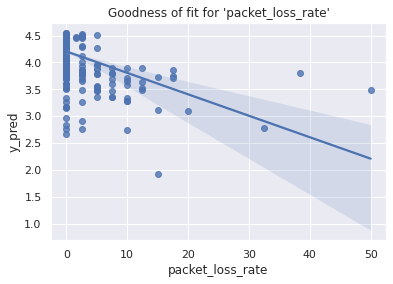

In [36]:
regplt = sns.regplot(x="packet_loss_rate", y="y_pred", data=plot_df)
regplt.set_title("Goodness of fit for 'packet_loss_rate'")

In [38]:
# Creating a df with feature to plot against
plot_df = pd.DataFrame()
plot_df['signal_strength'] = X_test['signal_strength']
plot_df['y_test'] = y_test
plot_df['y_pred'] = y_pred
plot_df.sort_values(by=['signal_strength'], inplace=True)
plot_df

,signal_strength,y_test,y_pred
785,-80,4.391198,4.511743
790,-80,4.399698,4.552944
783,-80,4.392840,4.525220
791,-80,4.397528,4.538418
775,-80,1.128526,1.919789
...,...,...,...
299,-42,4.402016,4.488171
308,-42,4.399302,4.478261
285,-42,4.096410,3.859512
297,-42,4.400731,4.481755


Text(0.5, 1.0, "Goodness of fit for 'signal_strength'")

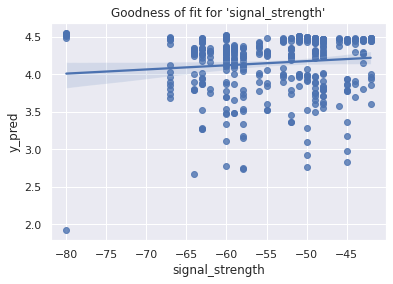

In [39]:
regplt = sns.regplot(x="signal_strength", y="y_pred", data=plot_df)
regplt.set_title("Goodness of fit for 'signal_strength'")

#Works Cited



*   https://seaborn.pydata.org/tutorial/aesthetics.html
*   https://seaborn.pydata.org/generated/seaborn.diverging_palette.html


*   https://seaborn.pydata.org/examples/many_pairwise_correlations.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


*   https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.round.html
*   https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e


*   https://www.pingman.com/kb/article/how-is-mos-calculated-in-pingplotter-pro-50.html







